## Spacenet

https://medium.com/the-downlinq/establishing-a-machine-learning-workflow-530628cfe67

https://medium.com/the-downlinq/object-detection-on-spacenet-5e691961d257

https://medium.com/the-downlinq/the-spacenet-metric-612183cc2ddb

https://medium.com/the-downlinq/a-baseline-model-for-the-spacenet-4-off-nadir-building-detection-challenge-6b7983312b4b

https://medium.com/the-downlinq

Fastai lesson 3

https://github.com/hiromis/notes/blob/master/Lesson3.md


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime
import uuid

In [3]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *


In [4]:
import PIL.Image as pil_image

In [5]:
import fastai
print(fastai.__version__)

1.0.32.dev0


In [6]:
torch.cuda.set_device(0)

In [7]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
print(f'DATE: {DATE}') 

DATE: 20181209


In [8]:
#bs of 8
#DATE='20181204'

In [9]:
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}') 

UID: b7d5fc19


In [10]:
#UID='81940436'

In [11]:
ARCH = models.resnet34
ARCH_NAME = 'rn34'
MODEL_NAME = 'unet'

In [12]:
SUB_NUM='1'

In [13]:
path = Path('../../data/SpaceNet_Off-Nadir_Dataset')

In [14]:
ssd_path = Path('../../ssd_data/SpaceNet_Off-Nadir_Dataset')
ssd_path.ls()

[PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_train'),
 PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/masks'),
 PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_masks'),
 PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_test')]

In [15]:
path_original_lbl = path/'masks'
path_original_img = path/'train_rgb'
fnames_original = get_image_files(path_original_img)
lbl_original_names = get_image_files(path_original_lbl)

In [16]:
path_hd_img = path/'resized_train'
path_hd_lbl = path/'resized_masks'
path_hd_test = path/'resized_test'

In [17]:
input_hd_test = path/'test_rgb'
input_test = ssd_path/'test_rgb'

In [18]:
path_img = ssd_path/'resized_train'
path_lbl = ssd_path/'resized_masks'
path_test = ssd_path/'resized_test'

In [19]:
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)
test_fnames = get_image_files(path_test)
fnames[:2], lbl_names[:2], test_fnames[:2] 

([PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_train/Pan-Sharpen_Atlanta_nadir8_catid_10300100023BC100_743051_3741339.png'),
  PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_train/Pan-Sharpen_Atlanta_nadir50_catid_10300100039E6200_743951_3724689.png')],
 [PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_masks/mask_739901_3739539.png'),
  PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_masks/mask_744851_3734139.png')],
 [PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_test/Pan-Sharpen_Atlanta_nadir36_catid_1030010003895500_739451_3738639.png'),
  PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_test/Pan-Sharpen_Atlanta_nadir21_catid_1030010003127500_734951_3745839.png')])

In [20]:
len(fnames), len(lbl_names), len(test_fnames)

(28728, 1064, 927)

In [21]:
#only 1064 masks and images - but multiple nadirs

In [22]:
image_ids =[]
image_names=[]
channel_types=[]
nadir_angles=[]
mask_names=[]
nadir_types=[]
for n in fnames:
    parts = str(n).split('_')
    im_id = '_'.join(parts[-2:])
    image_ids.append(im_id)
    indici = [i for i, s in enumerate(parts) if 'nadir' in s]
    indici=indici[0]
    
    nadir_angle = parts[indici].split('nadir')[1]
    nadir_angles.append(nadir_angle)
    if int(nadir_angle) < 26:
        angle_set = 'nadir'
    elif int(nadir_angle) > 25 and int(nadir_angle) < 40:
        angle_set = 'offnadir'
    elif int(nadir_angle) > 40:
        angle_set = 'faroffnadir'
    nadir_types.append(angle_set)
    
    fname_part = str(n).split('/')[-1]
    image_names.append(fname_part)
    
    channel_type = str(fname_part).split('Atlanta')[0][:-1]
    channel_types.append(channel_type)
    
    mask_name = 'mask_'+im_id
    mask_names.append(mask_name)

In [23]:
len(list(set(image_ids)))

1064

In [24]:
train_df = pd.DataFrame(
    {'image_name': image_names,
     'channel_type': channel_types,
     'nadir_angle': nadir_angles,
     'nadir_type': nadir_types,
     'mask_name': mask_names
    })

In [25]:
train_df.head()


,image_name,channel_type,nadir_angle,nadir_type,mask_name
0,Pan-Sharpen_Atlanta_nadir8_catid_10300100023BC...,Pan-Sharpen,8,nadir,mask_743051_3741339.png
1,Pan-Sharpen_Atlanta_nadir50_catid_10300100039E...,Pan-Sharpen,50,faroffnadir,mask_743951_3724689.png
2,Pan-Sharpen_Atlanta_nadir19_catid_1030010003C9...,Pan-Sharpen,19,nadir,mask_739901_3727839.png
3,Pan-Sharpen_Atlanta_nadir13_catid_1030010002B7...,Pan-Sharpen,13,nadir,mask_741701_3721089.png
4,Pan-Sharpen_Atlanta_nadir49_catid_103001000349...,Pan-Sharpen,49,faroffnadir,mask_743951_3726039.png


In [26]:
train_df['channel_type'].unique()

array(['Pan-Sharpen'], dtype=object)

In [27]:
train_df['nadir_angle'].unique()

array(['8', '50', '19', '13', '49', '29', '32', '53', '25', '27', '10', '42', '34', '30', '14', '44', '52', '16', '46',
       '47', '7', '23', '39', '21', '36'], dtype=object)

In [28]:
mask_n = train_df['mask_name'][0]
mask = open_mask(path_lbl/f'{mask_n}', div=True)
src_size = np.array(mask.shape[1:])

In [29]:
mask.shape[1:], src_size

(torch.Size([450, 450]), array([450, 450]))

## Make DataBunch

In [30]:
size = src_size
bs=4

In [31]:
codes = np.array(['nadir','offnadir','faroffnadir'])

In [32]:
holdout_grids = ['735851','747551','741251','746201']
valid_idx = [i for i,o in enumerate(fnames) if any(c in str(o) for c in holdout_grids)]

In [33]:
len(valid_idx)

3321

In [34]:
def get_y_fn(full_name):
    parts = str(full_name).split('_')
    im_id = '_'.join(parts[-2:])
    mask_name = 'mask_'+im_id
    return path_lbl/f'{mask_name}'

In [59]:
# overriding to set open_mask(fn, div=True), probably a better way to do this
# idea from https://forums.fast.ai/t/unet-binary-segmentation/29833/19

class MySegmentationLabelList(ImageItemList):
    def __init__(self, items:Iterator, classes:Collection=codes, **kwargs):
        super().__init__(items, **kwargs)
        self.classes,self.loss_func = classes,CrossEntropyFlat(),partial(open_mask, div=True)
        self.c = len(self.classes)

    def new(self, items, classes=None, **kwargs):
        return self.__class__(items, ifnone(classes, self.classes), **kwargs)

    def open(self, fn): return open_mask(fn, div=True)
    
class MySegmentationItemList(ImageItemList): 
    def __post_init__(self):
        super().__post_init__()
        self._label_cls = MySegmentationLabelList

In [60]:
#if dont have split_by_idx then get wrong type

In [61]:
def dice(input:Tensor, targs:Tensor, iou:bool=True)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input*targs).sum().float()
    union = (input+targs).sum().float()
    if not iou: return 2. * intersect / union
    else: return intersect / (union-intersect+1.0)

In [62]:
def create_my_data():
    src = (SegmentationItemList.from_folder(path_img)
        .random_split_by_pct(0.2)
        .label_from_func(get_y_fn, classes=codes))
    tfms = get_transforms(flip_vert=True, max_warp=0, max_zoom=1.2, max_lighting=0.3)
    data = (src.transform(tfms, size=size, tfm_y=True)
            .databunch(bs=bs)
            .normalize(imagenet_stats))
    return src, tfms, data

In [63]:
def create_data():
    src = (SegmentationItemList.from_folder(path_img)
        .split_by_idx(valid_idx)
        .label_from_func(get_y_fn, classes=codes))
    tfms = get_transforms(flip_vert=True, max_warp=0, max_zoom=1.2, max_lighting=0.3)
    #transform mask in same way as image - tfm_y=True
    data = (src.transform(tfms, size=size, tfm_y=True)
            .databunch(bs=bs)
            .normalize(imagenet_stats))
    return src, tfms, data

In [64]:
src, tfms, data = create_my_data()

In [65]:
#src, tfms, data = create_data()

In [66]:
#data.show_batch(2, figsize=(10,7))

In [67]:
#data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

### save data for later re-load

In [68]:
data.export()

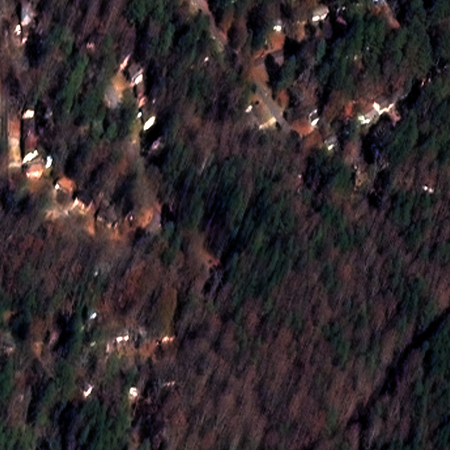

In [69]:
data.train_ds.x[1]

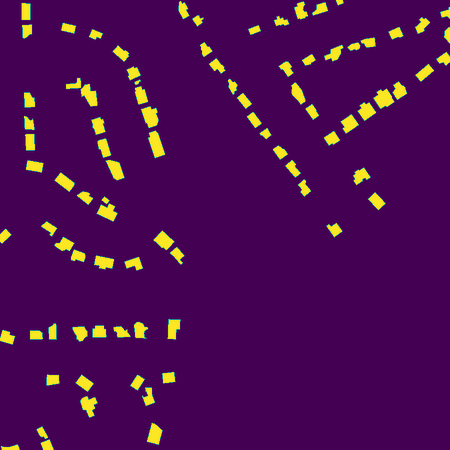

In [70]:
data.train_ds.y[1]

In [71]:
data.train_ds.y[1].data

tensor([[[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         ...,
         [  7, 186, 255,  ...,   0,   0,   0],
         [  0, 116, 251,  ...,   0,   0,   0],
         [  0, 128, 255,  ...,   0,   0,   0]]])

In [72]:
#data.show_batch(2,figsize=(4,4))

In [73]:
#data.show_batch(2,figsize=(4,4), ds_type=DatasetType.Valid)

## Train

In [74]:
iou = partial(dice, iou=True)
metrics = [iou, dice]

In [75]:
learn = unet_learner(data, ARCH, metrics=metrics)

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch-nightly_1543485201286/work/aten/src/THC/generic/THCTensorCopy.cpp:20

In [51]:
#cant do this with dynamic unet
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1])

In [52]:
#layer_groups_total = len(learn.layer_groups[0])
#for i in range(layer_groups_total):
#    learn.layer_groups[0][i] = nn.DataParallel(learn.layer_groups[0][i], device_ids=[0, 1])

In [53]:
learn.lr_find()
learn.recorder.plot()

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch-nightly_1543485201286/work/aten/src/THC/generic/THCTensorCopy.cpp:20

In [ ]:
lr = 1e-3

In [ ]:
learn.fit_one_cycle(3, max_lr=lr)

In [ ]:
learn.save(f'{DATE}-{ARCH_NAME}-{MODEL_NAME}-stage1')

In [ ]:
learn.load(f'{DATE}-{ARCH_NAME}-{MODEL_NAME}-stage1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, max_lr=slice(1e-5,lr/5))

In [ ]:
learn.save(f'{DATE}-{ARCH_NAME}-{MODEL_NAME}-stage2')

In [ ]:
learn.load(f'{DATE}-{ARCH_NAME}-{MODEL_NAME}-stage2')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
def acc_fixed(input, targs):
    #input.shape: torch.Size([4, 3, 450, 450]), targs.shape: torch.Size([4, 1, 450, 450]) 
    n = targs.shape[0]
    targs = targs.squeeze(1)
    #reshape the tensor to n rows, unknown number of columns
    targs = targs.view(n,-1)
    #targs.view: torch.Size([4, 202500])
    #Returns the indices of the maximum values along an axis
    input = input.view(n,3,-1).argmax(dim=1)
    #input.view: torch.Size([4, 202500])
    return (input==targs).float().mean()

In [ ]:
learn.metrics = [acc_fixed, iou, dice]

In [ ]:
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-3))

In [ ]:
learn.save(f'{DATE}-{ARCH_NAME}-{MODEL_NAME}-stage2_2')

In [ ]:
learn.model.train()

In [ ]:
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-3))

In [ ]:
learn.save(f'{DATE}-{ARCH_NAME}-{MODEL_NAME}-stage3')

## Preds

https://spacenetchallenge.github.io/datasets/spacenet-OffNadir-summary.html

In the SpaceNet Off-Nadir Building Extraction Challenge, the metric for ranking entries is the SpaceNet Metric.
This metric is an F1-Score based on the intersection over union of two building footprints with a threshold of 0.5

F1-Score is calculated by taking the total True Positives, False Positives, and False Negatives for each nadir segement and then averaging the F1-Score for each segement.

F1-Score Total = mean(F1-Score-Nadir, F1-Score-Off-Nadir, F1-Score-Very-Off-Nadir)

Your output must be a CSV file with almost identical format to the building footprint definition files.

ImageId,BuildingId,PolygonWKT_Pix,Confidence

Your output file may or may not include the above header line. The rest of the lines should specify the buildings your algorithm extracted, one per line.

The required fields are:

ImageId is a string that uniquely identifies the image.
BuildingId is an integer that identifies a building in the image, it should be unique within an image and must be positive unless the special id of -1 is used. -1 must be used to signal that there are no buildings in the image.
PolygonWKT_Pix specifies the points of the shape that represents the building you found. The format is exactly the same as given above in the Input files section. Important to know that the coordinates must be given in the scale of the 3-band images. So if you find a building that has a corner at (40, 20) on the 3-band image and (10, 5) on the corresponding 8-band image then your output file should have a (40 20 0) coordinate triplet listed in the shape definition.
Confidence is a positive real number, higher numbers mean you are more confident that this building is indeed present. See the details of scoring for how this value is used.
Your output must be a single file with .csv extension. Optionally the file may be zipped, in which case it must have .zip extension. The file must not be larger than 150MB and must not contain more than 2 million lines.

Your algorithm must process the image tiles of the test set one by one, that is when you are predicting building footprints you must not use information from other tiles of the test set.


In [ ]:
path_test = path/'resized_test'
test_fnames = get_image_files(path_test)

In [ ]:
learn.load(f'{DATE}-{ARCH_NAME}-{MODEL_NAME}-stage3')
learn.model.eval()

In [ ]:
def pred_images(test_file_names):
    #im_files = glob.glob(f"{test_path}/*.png")
    i=0
    for fname in test_file_names:
        # load image and predict
        img = open_image(fname)
        pred_class, pred_idx, outputs = learn.predict(img)
        if i<10:
            display(img); display(names[pred_class]); display(outputs)
        i+=1

In [ ]:
pred_images(test_fnames)

In [ ]:
outputs.shape

In [ ]:
plt.imshow((to_np(outputs[0][1])))

In [ ]:
for i in range(20):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow((to_np(outputs[i][1])), alpha=0.6)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    data.valid_ds.y[i].show(ax=ax2, alpha=0.6)
    plt.show()

In [ ]:
# see stpacenetutilities.labeltools.corelabeltools createGeoJSONFromRaster